In [318]:
import pennylane as qml
from pennylane import numpy as np
import covalent as ct
import matplotlib.pyplot as plt
from pennylane.optimize import NesterovMomentumOptimizer

In [319]:
dev = qml.device("default.qubit", wires=4)

In [320]:
@ct.electron
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

In [321]:
@ct.electron
def statepreparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])

In [322]:
@ct.electron
@qml.qnode(dev)
def circuit(weights, x):

    qml.BasisState(x, wires=[0, 1, 2, 3])

    for W in weights:
        qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
        qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
        qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
        qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

        qml.CNOT(wires=[0, 1])
        qml.CNOT(wires=[1, 2])
        qml.CNOT(wires=[2, 3])
        qml.CNOT(wires=[3, 0])

    return qml.expval(qml.PauliZ(0))

In [323]:
@ct.electron
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [324]:
@ct.electron
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [325]:
@ct.electron
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [326]:
@ct.electron
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [327]:
@ct.electron
def get_optimizer():
    return NesterovMomentumOptimizer(0.25)

In [328]:
@ct.electron
def weights_bias_init(num_layers,num_qubits):
    weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
    bias_init = np.array(0.0, requires_grad=True)
    return weights_init,bias_init

In [329]:
@ct.electron
def training(opt,weights,bias,epochs,batch_size,X,Y,num_layers,num_qubits,cost):
    #weights,bias = weights_bias_init(num_layers,num_qubits)
    training_steps = []
    cost_steps = []
    accuracy_steps = []
    for it in range(epochs):
        batch_index = np.random.randint(0, len(X), (batch_size,))
        X_batch = X[batch_index]
        Y_batch = Y[batch_index]
        weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

        # Compute accuracy
        predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
        acc = accuracy(Y, predictions)
        training_steps.append(i)
        cost_steps.append(cost(weights, bias, X, Y))
        accuracy_steps.append(acc)
        
        print("Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(it + 1, cost(weights, bias, X, Y), acc))
    
    return weights,bias,training_steps,cost_steps,accuracy_steps

In [330]:
@ct.lattice
def workflow(epochs,num_layers,num_qubits,X,Y):
    opt = get_optimizer()
    weights,bias = weights_bias_init(num_layers,num_qubits)
    batch_size = 5
    weights,bias,training_steps,cost_steps,accuracy_steps = training(opt,weights,bias,epochs,batch_size,X,Y,num_layers,num_qubits,cost)
    return weights,bias,training_steps,cost_steps,accuracy_steps
    

In [331]:
data = np.loadtxt("./parity.txt")
X = np.array(data[:, :-1], requires_grad=False)
Y = np.array(data[:, -1], requires_grad=False)
Y = Y * 2 - np.ones(len(Y))  # shift label from {0, 1} to {-1, 1}

for i in range(5):
    print("X = {}, Y = {: d}".format(X[i], int(Y[i])))

print("...")

X = [0. 0. 0. 0.], Y = -1
X = [0. 0. 0. 1.], Y =  1
X = [0. 0. 1. 0.], Y =  1
X = [0. 0. 1. 1.], Y = -1
X = [0. 1. 0. 0.], Y =  1
...


In [332]:

dispatch_id = ct.dispatch(workflow)(X=X,Y=Y,epochs=25,num_layers=2,num_qubits=4)
result = ct.get_result(dispatch_id=dispatch_id,wait=True)#,results_dir="./")
weights,bias,training_steps,cost_steps,accuracy_steps = result.result


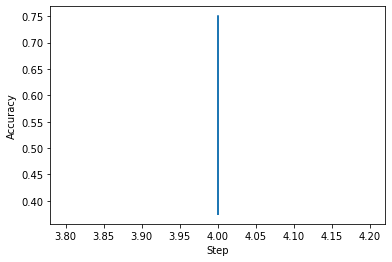

In [333]:
plt.plot(training_steps, accuracy_steps)
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.show()